### Imports

In [1]:
import cv2
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from random import shuffle

np.warnings.filterwarnings('ignore')
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, Conv2D, Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

from Models import VGG, Resnet

Using TensorFlow backend.


## Step 1 (Preprocessing)

### Parameters

In [2]:
# BASE_DIR = '/mnt/540a2327-e51d-4d2a-8ba0-16091f53a714/Data/Machine Learning/Datasets/BACH/'

BASE_DIR = './dataset/'

TRAIN_PHOTOS_DIR = BASE_DIR + 'ICIAR2018_BACH_Challenge/Photos/'

TEST_PHOTOS_DIR = BASE_DIR + 'ICIAR2018_BACH_Challenge_TestDataset/Photos/'

CLASSES = ['Invasive', 'InSitu', 'Normal', 'Benign']

NUM_CLASSES = len(CLASSES)

IMG_SIZE = 500

TRAIN_TEST_RATIO = 0.8

LOAD_MATRICES = False

SAVE_MATRICES = False

num_epochs = 100

lr = 0.00001

### Load and Save Functions

In [3]:
def save_matrices(x, y):
    np.save('./Matrices/X.npy', x)
    np.save('./Matrices/Y.npy', y)
    print("Matrices are all saved!")
    return


def load_matrices():
    X = np.load('./Matrices/X.npy')
    Y = np.load('./Matrices/Y.npy')
    print("Matrices are all loaded!")
    return X, Y

### Shuffle Data Function

In [4]:
def shuffle_data(x, y):
    z = list(zip(x, y))
    shuffle(z)
    x, y = zip(*z)
    return np.asarray(x), np.asarray(y)

### Split Data to Train and Test Function

In [5]:
def split_to_train_test(arr, ratio):
    assert type(ratio) == float

    number_of_train_samples = np.int(len(arr) * ratio)
    number_of_test_samples = len(arr) - number_of_train_samples

    train_arr, test_arr = arr[:number_of_train_samples], arr[number_of_train_samples:]
    return train_arr, test_arr

### Obtain X, Y

In [6]:
if LOAD_MATRICES:
    X, Y = load_matrices()
else:
    X = []
    Y = []

    for idx, class_name in enumerate(CLASSES):
        CLASS_TRAIN_PHOTOS_DIR = TRAIN_PHOTOS_DIR + class_name
        for img_name in os.listdir(CLASS_TRAIN_PHOTOS_DIR):
            if img_name.split(".")[1] == 'tif':
                IMG_DIR = CLASS_TRAIN_PHOTOS_DIR + '/%s' % img_name
                img = image.load_img(IMG_DIR, target_size=(IMG_SIZE, IMG_SIZE))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
    #           img = cv2.imread(IMG_DIR)
    #           img.resize((IMG_SIZE, IMG_SIZE, 3))
    #           img = img.astype('float64') / 255.
                X.append(x)
                Y.append(idx)
                print(img_name, idx)

    X = np.asarray(X)
    print(np.asarray(Y).shape)
    Y = np.asarray(to_categorical(Y))
    
    X = np.vstack(X)
    Y = np.vstack(Y)
    if SAVE_MATRICES:
        save_matrices(X, Y)
        print("Matrices saved!")

iv070.tif 0
iv043.tif 0
iv095.tif 0
iv087.tif 0
iv074.tif 0
iv014.tif 0
iv094.tif 0
iv049.tif 0
iv090.tif 0
iv033.tif 0
iv065.tif 0
iv063.tif 0
iv025.tif 0
iv091.tif 0
iv060.tif 0
iv061.tif 0
iv068.tif 0
iv080.tif 0
iv037.tif 0
iv019.tif 0
iv099.tif 0
iv052.tif 0
iv001.tif 0
iv092.tif 0
iv069.tif 0
iv050.tif 0
iv055.tif 0
iv006.tif 0
iv032.tif 0
iv079.tif 0
iv064.tif 0
iv081.tif 0
iv047.tif 0
iv029.tif 0
iv076.tif 0
iv054.tif 0
iv007.tif 0
iv027.tif 0
iv078.tif 0
iv044.tif 0
iv097.tif 0
iv072.tif 0
iv073.tif 0
iv036.tif 0
iv067.tif 0
iv021.tif 0
iv011.tif 0
iv058.tif 0
iv046.tif 0
iv024.tif 0
iv010.tif 0
iv038.tif 0
iv077.tif 0
iv013.tif 0
iv082.tif 0
iv017.tif 0
iv089.tif 0
iv066.tif 0
iv012.tif 0
iv053.tif 0
iv026.tif 0
iv030.tif 0
iv057.tif 0
iv040.tif 0
iv003.tif 0
iv083.tif 0
iv041.tif 0
iv004.tif 0
iv098.tif 0
iv031.tif 0
iv015.tif 0
iv051.tif 0
iv048.tif 0
iv093.tif 0
iv008.tif 0
iv034.tif 0
iv088.tif 0
iv075.tif 0
iv056.tif 0
iv016.tif 0
iv084.tif 0
iv028.tif 0
iv100.tif 0
iv02

### Shuffling X, Y

In [7]:
X, Y = shuffle_data(X, Y)

### Compute Subsets

In [8]:
x_train, x_test = split_to_train_test(X, TRAIN_TEST_RATIO)
y_train, y_test = split_to_train_test(Y, TRAIN_TEST_RATIO)

In [9]:
print("X Train Shape:", x_train.shape)
print("Y Train Shape:", y_train.shape)
print("X Test Shape:", x_test.shape)
print("Y Test Shape:", y_test.shape)

X Train Shape: (320, 500, 500, 3)
Y Train Shape: (320, 4)
X Test Shape: (80, 500, 500, 3)
Y Test Shape: (80, 4)


## Step2 (Model Selection)

In [10]:
vgg_model = VGG(model_name='My_VGG16',
                input_shape=(IMG_SIZE, IMG_SIZE, 3),
                input_layer_name='input_layer',
                num_classes=NUM_CLASSES)


# res_model = Resnet(input_layer_name='input_layer',
#                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
#                    num_classes=NUM_CLASSES)

### Creating Model

In [11]:
model = vgg_model.construct_net()
# model = res_model.construct_net()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 167, 167, 64)      0         
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 167, 167, 128)     73856     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 83, 83, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 83, 83, 256)       295168    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 41, 41, 256)       0   

### Compiling Model

In [12]:
if NUM_CLASSES != 2:
    model.compile(optimizer=Adam(learning_rate=lr, decay=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
else:
    model.compile(optimizer=Adam(learning_rate=lr, decay=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


### Test GPU Available

In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Fitting Model

In [14]:
history = model.fit(x=x_train, y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=num_epochs,
                    verbose=1)

Train on 320 samples, validate on 80 samples
Epoch 1/100
320/320 [==============================] - 11s 35ms/step - loss: 14.7534 - accuracy: 0.2500 - val_loss: 12.3126 - val_accuracy: 0.2875
Epoch 2/100
320/320 [==============================] - 5s 15ms/step - loss: 12.0600 - accuracy: 0.3219 - val_loss: 12.1017 - val_accuracy: 0.2875
Epoch 3/100
320/320 [==============================] - 5s 15ms/step - loss: 11.5206 - accuracy: 0.4344 - val_loss: 11.8374 - val_accuracy: 0.3750
Epoch 4/100
320/320 [==============================] - 5s 15ms/step - loss: 11.3880 - accuracy: 0.4781 - val_loss: 11.6321 - val_accuracy: 0.3625
Epoch 5/100
320/320 [==============================] - 5s 15ms/step - loss: 11.1972 - accuracy: 0.5594 - val_loss: 11.6182 - val_accuracy: 0.4375
Epoch 6/100
320/320 [==============================] - 5s 15ms/step - loss: 11.1180 - accuracy: 0.5938 - val_loss: 11.6070 - val_accuracy: 0.4125
Epoch 7/100
320/320 [==============================] - 5s 15ms/step - loss: 11

320/320 [==============================] - 5s 16ms/step - loss: 9.9284 - accuracy: 1.0000 - val_loss: 10.9808 - val_accuracy: 0.5500
Epoch 57/100
320/320 [==============================] - 5s 16ms/step - loss: 9.9233 - accuracy: 0.9969 - val_loss: 11.0002 - val_accuracy: 0.5625
Epoch 58/100
320/320 [==============================] - 5s 16ms/step - loss: 9.9159 - accuracy: 1.0000 - val_loss: 10.9766 - val_accuracy: 0.5625
Epoch 59/100
320/320 [==============================] - 5s 16ms/step - loss: 9.9082 - accuracy: 1.0000 - val_loss: 10.9876 - val_accuracy: 0.5250
Epoch 60/100
320/320 [==============================] - 5s 16ms/step - loss: 9.9022 - accuracy: 1.0000 - val_loss: 10.9759 - val_accuracy: 0.5375
Epoch 61/100
320/320 [==============================] - 5s 16ms/step - loss: 9.8951 - accuracy: 0.9969 - val_loss: 10.9575 - val_accuracy: 0.5625
Epoch 62/100
320/320 [==============================] - 5s 16ms/step - loss: 9.8877 - accuracy: 1.0000 - val_loss: 10.9733 - val_accuracy

### Plotting Accuracy and Loss

In [15]:
def plot_history(history):
    %matplotlib inline

    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) 

    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.figure()

    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    plt.title('Training and validation Loss')
    plt.figure()

    ACC_PLOT_NAME = '%s_classes_%s_epochs_%.4f_%.4f.png' % (4, 200, acc[-1], val_acc[-1])
    LOSS_PLOT_NAME = '%s_classes_%s_epochs_%.4f_%.4f.png' % (4, 200, loss[-1], val_loss[-1])

    ACC_PLOT_DIR = os.path.join('./plots/acc/', ACC_PLOT_NAME) 
    LOSS_PLOT_DIR = os.path.join('./plots/loss/', LOSS_PLOT_NAME)
    return

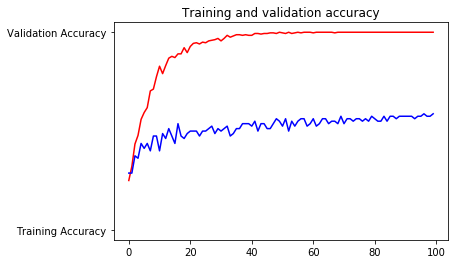

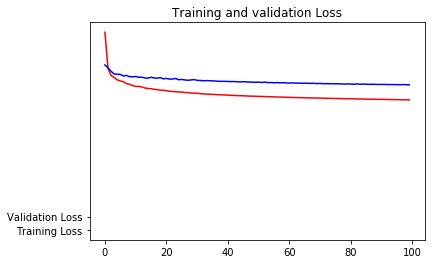

<Figure size 432x288 with 0 Axes>

In [16]:
plot_history(history)

## Evaluating Test set

### Reading Test Images

In [17]:
def read_test_images(test_dir):
    test_imgs = []
    img_names = os.listdir(test_dir)
    print("Started reading images.")
    for img_name in img_names:
        img_path = test_dir + img_name
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        test_imgs.append(x)
        
    
    test_imgs = np.asarray(test_imgs)
    test_imgs = np.vstack(test_imgs)
    print("Reading images finished!")
    return test_imgs

In [18]:
test_images = read_test_images(TEST_PHOTOS_DIR)

Started reading images.
Reading images finished!


### Predicting Test set

In [19]:
preds = model.predict(test_images)

In [20]:
preds = [np.argmax(i) for i in preds]

In [21]:
print("Predictions:", preds)

Predictions: [2, 1, 0, 3, 0, 2, 3, 0, 2, 3, 0, 3, 3, 0, 3, 1, 3, 1, 3, 2, 2, 0, 1, 0, 3, 2, 1, 1, 1, 2, 3, 1, 0, 1, 2, 2, 2, 3, 3, 2, 1, 3, 3, 2, 2, 3, 0, 2, 1, 2, 1, 0, 0, 3, 2, 2, 2, 2, 0, 3, 1, 1, 3, 0, 0, 1, 1, 2, 3, 3, 0, 2, 1, 3, 3, 0, 3, 3, 2, 2, 0, 0, 0, 3, 1, 0, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 1, 2, 3, 3]


### Composing CSV File

In [22]:
def create_csv_file(preds):
    with open('pred.cvs', 'w+') as file:
        file.write('case,class\n')
        for idx, pred in enumerate(preds):
            file.write(str(idx) + ',' + str(pred) + '\n')
    ZipObj = zipfile.ZipFile('predictions.zip', 'w')
    ZipObj.write('pred.cvs')
    print("File predictions.zip created successfully.")
    return

In [23]:
if os.path.exists('./predictions.zip'):
    !rm -rf predictions.zip
    print("Previous Predictions.zip has been removed.")

Previous Predictions.zip has been removed.


In [24]:
create_csv_file(preds)

File predictions.zip created successfully.
